# Import

In [57]:
from tqdm.auto import tqdm
import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neural_network import BernoulliRBM, MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Load

In [62]:
PATH_DATA = '/Users/nicolapitzalis/Documents/uni-ai/HLT/HLT-Project/dataset/distilbert_results/ner_recipes_balanced_cleaned.csv'
PATH_LABELS = '/Users/nicolapitzalis/Documents/uni-ai/HLT/HLT-Project/dataset/distilbert_results/ner_labels_balanced.csv'
PATH_VOCABULARY = '/Users/nicolapitzalis/Documents/uni-ai/HLT/HLT-Project/dataset/distilbert_results/ner_ingredients_balanced_cleaned.csv'
# PATH_RECIPES = '/Users/nicolapitzalis/Documents/uni-ai/HLT/HLT-Project/dataset/recipes_df_r.csv'

data = pd.read_csv(PATH_DATA)
vocabulary = pd.read_csv(PATH_VOCABULARY, header=None)
labels = pd.read_csv(PATH_LABELS)

In [76]:
all_nan_rows = data[data.isna().all(axis=1)]

In [77]:
all_nan_rows.shape

(98, 43)

In [3]:
# recipes = pd.read_csv(PATH_RECIPES)
# labels = recipes['Vegetarian']
# labels.to_csv(PATH_LABELS, index=False)

# Preprocessing

In [63]:
vocabulary = vocabulary.fillna('Missing')
ohe_vocabulary = pd.get_dummies(vocabulary, prefix='category').astype(int)  # Replace '0' with the actual column name if it exists

In [64]:
# Initialize an empty list to hold the one-hot encoded recipes
ohe_matrix = []

# Loop over each recipe in the data
for index, recipe in data.iterrows():
    # Initialize a one-hot encoded array for the recipe
    ohe_recipe = np.zeros(len(ohe_vocabulary.columns))
    
    # Loop over each ingredient in the recipe
    for ingredient in recipe:
        if pd.isnull(ingredient):
            continue
        
        # Check if the ingredient is in the one-hot vocabulary
        if f'category_{ingredient}' in ohe_vocabulary.columns:
            # Find the index for the ingredient
            ingredient_index = ohe_vocabulary.columns.get_loc(f'category_{ingredient}')
            
            # Set the corresponding position in ohe_recipe to 1
            ohe_recipe[ingredient_index] = 1

    # Append the one-hot encoded recipe to the matrix
    ohe_matrix.append(ohe_recipe)

# Convert the list of arrays into a 2D NumPy array
ohe_matrix = np.array(ohe_matrix)

In [65]:
ohe_matrix.shape

(9868, 5673)

In [66]:
ohe_matrix.sum()

104012.0

In [67]:
labels = labels['Vegetarian&Desserts'].to_numpy()

# Classification

In [68]:
X_train, X_test, y_train, y_test = train_test_split(ohe_matrix, labels, test_size=0.3, random_state=42, stratify=labels)

In [69]:
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

{0: 4900, 1: 4968}


In [70]:
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

{0: 3430, 1: 3477}


In [71]:
unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))

{0: 1470, 1: 1491}


## Random Forest

In [55]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]  
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.7min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.7min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.7min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.7min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.7min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.4min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.4min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 3.2min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 3.2min
[CV] END m

In [73]:
random_forest = RandomForestClassifier(criterion='gini', n_estimators=300, random_state=42, max_depth=None, min_samples_split=10, min_samples_leaf=1, n_jobs=-1)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.81      0.79      1470
           1       0.80      0.76      0.78      1491

    accuracy                           0.79      2961
   macro avg       0.79      0.79      0.79      2961
weighted avg       0.79      0.79      0.79      2961



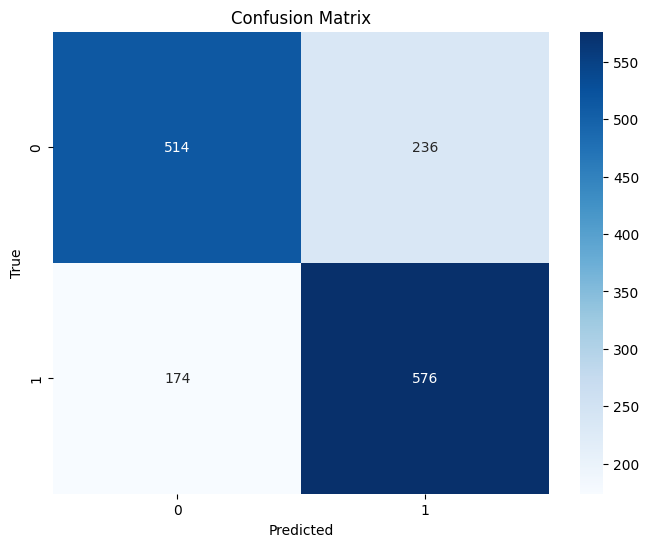

In [21]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [61]:
for i, tree in enumerate(random_forest.estimators_):
    tree_rules = export_text(tree, feature_names=list(ohe_vocabulary.columns))
    
    print(f"Rules for tree {i}:\n")
    print(tree_rules)
    print("\n")

Rules for tree 0:

|--- category_confectione <= 0.50
|   |--- category_tomato <= 0.50
|   |   |--- category_mushroom <= 0.50
|   |   |   |--- category_chicken stock <= 0.50
|   |   |   |   |--- category_lime juice <= 0.50
|   |   |   |   |   |--- category_garlic <= 0.50
|   |   |   |   |   |   |--- category_sourdough bread <= 0.50
|   |   |   |   |   |   |   |--- category_garlic powder <= 0.50
|   |   |   |   |   |   |   |   |--- category_eye <= 0.50
|   |   |   |   |   |   |   |   |   |--- category_chocolate <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- category_butter <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 283
|   |   |   |   |   |   |   |   |   |   |--- category_butter >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 131
|   |   |   |   |   |   |   |   |   |--- category_chocolate >  0.50
|   |   |   |   |   |   |   |   |   |   |--- category_sesame seed <= 0.50
|   |   |   |   |   |   |   |   |   |  

## RBM + classifier

In [ ]:
rbm = BernoulliRBM(random_state=42, verbose=True)
logistic = LogisticRegression(max_iter=1000)
classifier = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])

param_grid = {
    'rbm__learning_rate': [0.01, 0.1, 0.5],
    'rbm__n_iter': [20, 40, 80],
    'rbm__n_components': [50, 100, 200]  # number of hidden units
}

grid_search = GridSearchCV(classifier, param_grid, n_jobs=-1, cv=3)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))


In [ ]:
rbm = BernoulliRBM(n_components=30, learning_rate=0.1, n_iter=40, random_state=42, verbose=True)
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, alpha=0.0001,
                    solver='adam', verbose=10, random_state=21, learning_rate_init=0.01)

classifier = Pipeline(steps=[('rbm', rbm), ('mlp', mlp)])
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))


## MLP

In [58]:
pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('mlp', MLPClassifier(max_iter=1000))  # Increased max_iter for convergence
])

parameter_space = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'mlp__activation': ['tanh', 'relu'],
    'mlp__solver': ['sgd', 'adam'],
    'mlp__alpha': [0.0001, 0.05],
    'mlp__learning_rate_init': [0.001, 0.01]
}

grid_search = GridSearchCV(pipeline, parameter_space, n_jobs=-1, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters found:\n", grid_search.best_params_)
print("Best score on train set:\n", grid_search.best_score_)
best_model = grid_search.best_estimator_
print("Test set score:\n", best_model.score(X_test, y_test))

Best parameters found:
 {'mlp__activation': 'relu', 'mlp__alpha': 0.05, 'mlp__hidden_layer_sizes': (100,), 'mlp__learning_rate_init': 0.001, 'mlp__solver': 'sgd'}
Best score on train set:
 0.759374223883991
Test set score:
 0.7524484971293482


In [74]:
mlp = MLPClassifier(hidden_layer_sizes=(1024, 512,), max_iter=300, alpha=0.0001, activation='relu',
                    solver='adam', verbose=10, random_state=21, learning_rate_init=0.01, learning_rate='invscaling')

mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Iteration 1, loss = 0.53743602
Iteration 2, loss = 0.30228895
Iteration 3, loss = 0.15201238
Iteration 4, loss = 0.07358082
Iteration 5, loss = 0.04684926
Iteration 6, loss = 0.03137430
Iteration 7, loss = 0.02167109
Iteration 8, loss = 0.01727525
Iteration 9, loss = 0.01787870
Iteration 10, loss = 0.01862596
Iteration 11, loss = 0.01681470
Iteration 12, loss = 0.01544460
Iteration 13, loss = 0.01599710
Iteration 14, loss = 0.01404279
Iteration 15, loss = 0.01434006
Iteration 16, loss = 0.02473036
Iteration 17, loss = 0.03609640
Iteration 18, loss = 0.08084052
Iteration 19, loss = 0.06207954
Iteration 20, loss = 0.04221940
Iteration 21, loss = 0.03224383
Iteration 22, loss = 0.02799388
Iteration 23, loss = 0.02547707
Iteration 24, loss = 0.02029128
Iteration 25, loss = 0.01894276
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.77      0.

Confusion Matrix:
[[512 238]
 [207 543]]


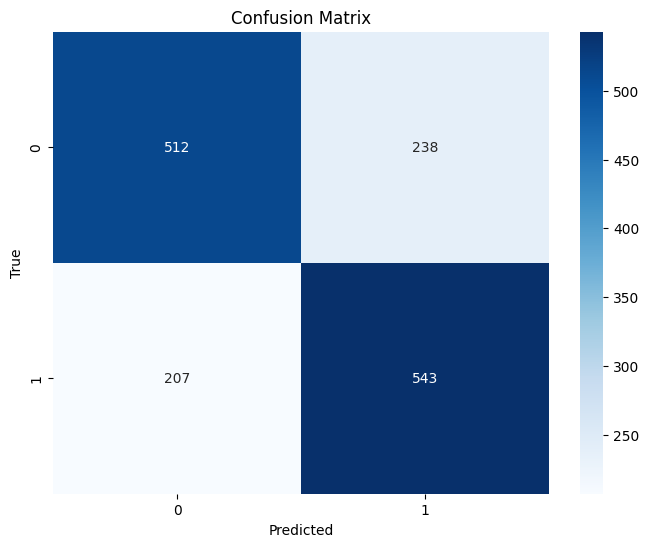

In [23]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## SVM

In [59]:
param_grid = [
    {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
]

svc = SVC()
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 3/5; 1/8] START C=1, gamma=0.001, kernel=rbf................................
[CV 5/5; 1/8] START C=1, gamma=0.001, kernel=rbf................................[CV 3/5; 2/8] START C=1, gamma=0.0001, kernel=rbf...............................[CV 4/5; 2/8] START C=1, gamma=0.0001, kernel=rbf...............................[CV 2/5; 2/8] START C=1, gamma=0.0001, kernel=rbf...............................[CV 1/5; 2/8] START C=1, gamma=0.0001, kernel=rbf...............................[CV 1/5; 3/8] START C=10, gamma=0.001, kernel=rbf...............................





[CV 1/5; 1/8] START C=1, gamma=0.001, kernel=rbf................................[CV 2/5; 3/8] START C=10, gamma=0.001, kernel=rbf...............................[CV 2/5; 1/8] START C=1, gamma=0.001, kernel=rbf................................[CV 4/5; 1/8] START C=1, gamma=0.001, kernel=rbf................................



[CV 5/5; 2/8] START C=1, gamma=0.0001, kernel=rbf

In [54]:
svc = SVC(C=100, kernel='rbf', gamma=0.001)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.71      0.76      1470
           1       0.75      0.84      0.79      1491

    accuracy                           0.78      2961
   macro avg       0.78      0.78      0.77      2961
weighted avg       0.78      0.78      0.77      2961



Confusion Matrix:
[[479 271]
 [134 616]]


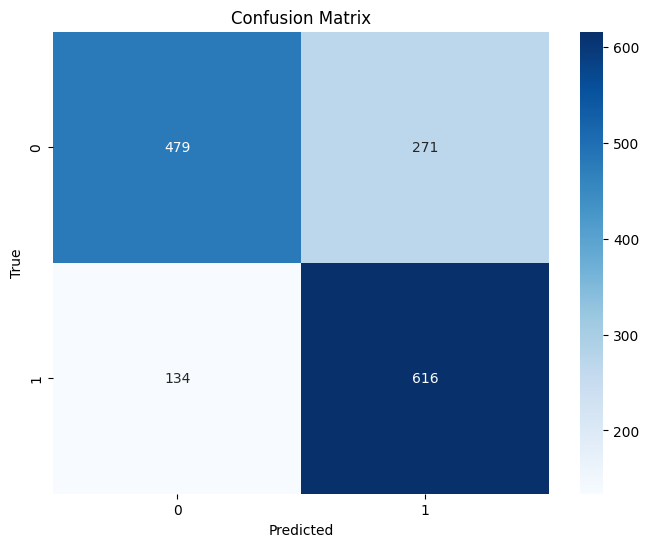

In [25]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()